In [7]:
kv=0

"""
Evaluate Hindi Files acc to diff template & anskey - Korba, Gwalior, Gonda _/ , Rajouri?

# ('OMR_Files_2017/Secunderabad_2060/JE/{}{}{}{}Normal/Mainpuri_JE_0045.tif', 'Secunderabad', '<<<<<<<')
# ('Bhilwara', '<<<<<<<', 'OMR_Files_2017/Bhilwara_5007/JE/Normal/Bhilawara_JE_0030.tif')
# ('najibabad', '<<<<<<<', 'OMR_Files_2017/najibabad_1147/JH/Normal/KV new tehri town_5135_JE_0003.tif')
# ('Bhiwadi', '<<<<<<<', 'OMR_Files_2017/Bhiwadi_5039/JH/Normal/amalapuram_JE_0079.tif')
# ('rewari', '<<<<<<<', 'OMR_Files_2017/rewari_1012/HH/Normal/Thrissur_HE_0001.tif')

"""
showimg= 0
verbose = 1 # Warning, the code may occasionally stop and showimg if verbose = 1
explain= 1
autorotate=0
saveMarked=1

#Intermediate - 
ext='.jpg'
# debug THR config - 
mw,mb=1,0
minWhiteTHR,maxBlackTHR=1,0
multimarkedTHR = 0.60
thresholdRead=  0.642 if kv else 0.70
thresholdCircle= 0.61

directory ='OMRs/KV_OMRs_2017/' if kv else 'OMRs/OMR_Files_2017/'
'feedsheets/errorSheet.csv'
errorpath=directory+'ErrorFiles/'
ErrorFile='feedsheets/ErrorFiles.csv'
WarningFile='feedsheets/WarningFiles.csv'
verifypath=directory+'verifyFiles/'
verifyFile='feedsheets/verifyFiles.csv'
badRollspath=directory+'badRollsFiles/'
badRollsFile='feedsheets/badRollsFiles.csv'
multiMarkedpath=directory+'multiMarkedFiles/'
multiMarkedFile='feedsheets/multiMarkedFiles.csv'
saveMarkedDir='markedOMRs/' #Should have Squad Langs inside
sheetCols=['batch','error','filename','path','roll']+['q'+str(i) for i in range(1,21)]+['t'+str(i) for i in range(1,6)]
resultSheetCols=sheetCols+['score']

results_2017batch=1000
results_2017error=11
multiMarkedError=12
badRollError=13
verifyError=14 #Goes into verifyFiles, can be ignored? -Nope, especially for kvs

In [8]:
# In[62]:
import re
import os
import cv2
import sys
import glob
from time import localtime,strftime,time
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils #thru the pip package.
# from skimage.filters import threshold_adaptive
import gi
gi.require_version('Gtk', '3.0')
from gi.repository import Gtk as gtk
# from gtk import Window
# window = Window()

In [9]:
# Some globals -
window=gtk.Window()
screen = window.get_screen()
# for positioning image windows
windowX,windowY = 0,0 

#windowWidth = screen.get_width()
#windowHeight = screen.get_height()
windowWidth = 1200
windowHeight = 700


# In[3]:

Directories = [multiMarkedpath,errorpath,verifypath,badRollspath]
print('Checking Directories...')

for dir in [saveMarkedDir]:
    if(not os.path.exists(dir)):
        print('Created : '+ dir)
        os.mkdir(dir)
        for sl in ['HE','HH','JE','JH']:
            os.mkdir(dir+sl)
            os.mkdir(dir+sl+'/_MULTI_')
            os.mkdir(dir+sl+'/_BadScan_')
    else:
        print('Already present : '+dir)

for dir in ['feedsheets','results']:
    if(not os.path.exists(dir)):
            print('Created : '+ dir)
            os.mkdir(dir)
    else:
        print('Already present : '+dir)
for dir in Directories:
    if(not os.path.exists(dir)):
        print('Created : '+ dir)
        os.mkdir(dir)
        for sl in ['HE','HH','JE','JH']:
            os.mkdir(dir+sl)
    else:
        print('Already present : '+dir)


# In[64]:

def pad(val,array):
    if(len(val) < len(array)):
        for i in range(len(array)-len(val)):
            val.append('V')

def appendArr(val,array,filename):
    array.append(val)
    if(not os.path.exists(filename)):
        with open(filename,'a') as f:
            pd.DataFrame([sheetCols],columns=sheetCols).to_csv(f,index=False,header=False)
    pad(val,sheetCols)
    with open(filename,'a') as f:
        pd.DataFrame([val],columns=sheetCols).to_csv(f,index=False,header=False)
        # pd.DataFrame(val).T.to_csv(f,header=False)


def waitQ():
    while(cv2.waitKey(1)& 0xFF != ord('q')):pass
    cv2.destroyAllWindows()

def show(name,img,pause=1,resetpos=None):
    global windowX
    global windowY
    if(type(img)== type(None)):
        print(name," NoneType image to show!")
        if(pause):
            cv2.destroyAllWindows()
        return
    cv2.imshow(name,img)
    
    w,h = img.shape
    if(resetpos):
        windowX=resetpos[0]
        windowY=resetpos[1]
    cv2.moveWindow(name,windowX,windowY)
    overflowX = windowX+w > windowWidth
    overflowY = windowY+h > windowHeight
    if(overflowX):
        windowX = 0
        if(not overflowY):windowY+=h
    else:windowX+=w
    if(overflowY):windowY = 0
    if(pause):
        waitQ()
    
def myColor1():
    return (randint(100,250),randint(100,250),randint(100,250))
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    minWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [minWidth - 1, 0],
        [minWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (minWidth, maxHeight))

    # return the warped image
    return warped
    


# In[4]:


# In[65]:
# a=[0.5,1.5,0,1,3,5,6]
# map(int,np.multiply(a,10))
# a = [a,a]
# pts = [[0,1],[1,0],[1,5],[0,5]]
# map(lambda x:a[x[0]][x[1]],sorted(pts,key=lambda pt: a[pt[0]][pt[1]],reverse=True))


# In[5]:


def dist(p1,p2):
    return np.linalg.norm(np.array(p1)-np.array(p2))
def getslope(pt1,pt2):
    return float(pt2[1]-pt1[1])/float(pt2[0]-pt1[0])
def check_min_dist(pt,pts,min_dist):
    for p in pts:
        if(dist(pt,p) < min_dist):
            return False
    return True
        
filesMoved=0
filesNotMoved=0
def move(error,filepath,filepath2,filename):
    global filesMoved
    # print(filepath,filepath2,filename,array)
    if(os.path.exists(filepath)):
        if(os.path.exists(filepath2+filename)):
            print('ERROR : Duplicate file at '+filepath2+filename)
        os.rename(filepath,filepath2+filename)
        append = [results_2017batch,error,filename,filepath2]
        filesMoved+=1
        return append
    else:
        print('File already moved')
        return None
        
def get_reflection(pt, pt1,pt2):
    pt, pt1,pt2 = tuple(map(lambda x:np.array(x,dtype=float),[pt, pt1,pt2]))
    return (pt1 + pt2) - pt
def printbuf(x):
    sys.stdout.write(str(x))
    sys.stdout.write('\r')

Checking Directories...
Already present : markedOMRs/
Already present : feedsheets
Already present : results
Created : OMRs/OMR_Files_2017/multiMarkedFiles/
Created : OMRs/OMR_Files_2017/ErrorFiles/
Created : OMRs/OMR_Files_2017/verifyFiles/
Created : OMRs/OMR_Files_2017/badRollsFiles/


In [10]:
# In[ ]:

thresholdCircles=[]
badThresholds=[]
veryBadPoints=[]
def match_template_scaled(errorsArray,squadlang,filepath,filename,img1, template,show_detected=False,pts=4,
                          scaleRange=(0.5,1.5),fac=50,min_dist=None,thresholdCircle=0.6,append=1,
                          CLR=(255,155,255),iterLim=30,excludepts=None):
    global errorpath
    lon='lon' if append==0 else 'non lon'
    orig=template.copy()
    w1,h1=img1.shape
    w,h=template.shape
    if( not min_dist):
        min_dist = h1/10
    scale=float(h1)/h
    print('image to template ratio (should be 38)',scale)
    x=list(map(int,np.multiply(scaleRange,fac)))
    if((x[1]-x[0])> iterLim*fac/10):
        print("Too many iterations : %d, reduce scaleRange" % ((x[1]-x[0])*10/fac) )
        return []
    r_max=None
    for r0 in range(x[1],x[0],-1*fac//10): #reverse order
        r=float(r0)/fac
        printbuf(r)
        if(r==0.0):
            continue
        templ = imutils.resize(orig, height = int(h*r))
        res = cv2.matchTemplate(img1,templ,cv2.TM_CCOEFF_NORMED)
#         cv2.imshow('res',res)        waitQ()
        maxT = res.max()
        if(thresholdCircle < maxT):
            printbuf(' %d )Better match %d%%' % (r0,100*maxT))
            r_max=r
            thresholdCircle = maxT
            
    if(r_max==None):
        if(append):
            print("No matchings for given scaleRange & thresholdCircle",scaleRange,thresholdCircle,lon)
        # this goes as resp=None in the main.
        err = move(results_2017error,filepath,errorpath+squadlang,filename)
        if(append and err):
            appendArr(err,errorsArray,ErrorFile)

        return [],0
    print('')
    if(r_max not in (0.85,0.9,0.95)):
        print('WARNING : Changed final scale',r_max,lon)
    templ = imutils.resize(orig, height = int(h*r_max))
    res = cv2.matchTemplate(img1,templ,cv2.TM_CCOEFF_NORMED)# better than TM_CCOEFF_NORMED)
#     show('res',res)    
    #Set thresholdCircle of top four points - 
    #argpartition : kth point will be in its sorted position i.e. k, others will be 'partitioned'
    res2  =  res.flatten() # serial thresholdCircle values.
    partitioned_res2=np.argpartition(a = res2,kth = -pts*2)
    thresholdCircle = min(res2[partitioned_res2[-pts*2:]])

#     NOW DISCARD NEARBY POINTS
    loc = np.where(res>=thresholdCircle) # now this already gives only pts*2 points
    locs = zip(*loc[::-1])
#     Now just order them by res values - for best match picked first
    locs = sorted(locs,key=lambda pt: res[pt[1]][pt[0]],reverse=True)
    w,h=templ.shape
    centres=[]
    i=0

    exclude = type(excludepts)!=type(None) and excludepts!=[]
    badscan = 0
    for pt in locs: #zipped because it gives Xs and Ys seperated & probab ordered by Xs
        if(i==pts):
            break
        if(check_min_dist(pt,centres,min_dist) and ( not exclude or (exclude and check_min_dist(pt,excludepts,min_dist)))):
            # print('adding pt ',pt,check_min_dist(pt,centres,min_dist),exclude,check_min_dist(pt,excludepts,min_dist))
            img1 = cv2.rectangle(img1,pt,(pt[0]+w,pt[1]+h),CLR,2)
            centres.append([pt[0]+w/2,pt[1]+h/2])
            thresholdCircles.append(res[pt[1]][pt[0]])
            
            i+=1
        else:
            badThresholds.append(res[pt[1]][pt[0]])
            print(locs,'WARNING Bad Scan : skipped nearby point', pt,res[pt[1]][pt[0]],'min_dist:',min_dist,centres,exclude,excludepts)
            badscan=1
            
        
    if(show_detected):
        show('detected',img1)    
    if(len(centres)<3):
        for pt in centres:
            veryBadPoints.append(res[pt[1]][pt[0]]);

    return np.array(centres),badscan

def get_fourth_pt(three_pts):
    m=[]
    for i in range(3):
        m.append(dist(three_pts[i],three_pts[(i+1)%3]))
        
    v =max(m)
    for i in range(3):
        if(m[i]!=v and m[(i+1)%3]!=v):
            refl = (i+1) % 3
            break
    fourth_pt = get_reflection( three_pts[refl],three_pts[(refl+1)%3],three_pts[(refl+2)%3])
    return fourth_pt


# In[7]:


# The Wrapper
def getROI(errorsArray,squadlang,filepath,filename,name,orig,templ,pause=0,lontemplinv=None,showimg=False,verbose=False,pts=3,scaleRange=(0.25,1.5),fac=100,
           thresholdCircle=0.55,thresholdLon=0.55,iterLim=50):
    template=templ.copy()
    image=orig.copy()
    #Add rotation here
    w,h=image.shape
    image=image-cv2.erode(image,None)
    template=template-cv2.erode(template,None)
    
    # excludepts=None
    #Manually adding the lon point
    excludepts = [[380,60]]
##
    """
    TODO+
    > Smoothening/Blurring for better template match!!
    """

    if( type(lontemplinv) != type(None)):
        lontemplateinv=lontemplinv.copy()
        lontemplateinv=lontemplateinv-cv2.erode(lontemplateinv,None)
        # show('lontemplateinv',lontemplateinv)
        p=float(w)/float(h)
        if(p<1):
            #90 or 180 works fine
            # print('Initiate Rotate by 90 - ')
            lontemplateinv = imutils.rotate_bound(lontemplateinv,angle= 270)
            
        excludepts,_ = match_template_scaled(errorsArray,squadlang,filepath,filename,image,lontemplateinv,
                                        show_detected=showimg,
                                        pts=1,
                                        append=0,
                                        scaleRange=scaleRange,fac=fac,thresholdCircle=thresholdLon,iterLim=iterLim)
        
        # print("Top location : ",excludepts)
        # show('lontemplateinv',lontemplateinv,0)

        if(excludepts!=[]):
            angle = 180 if excludepts[0][1] > 500 else ( 270 if excludepts[0][0] > 500 else 90)
            origin = h,w if angle == 180 else (h,0 if angle== 270 else (0,w if angle==90 else 0,0))
            # print(excludepts[0],origin,image.shape)
            #transpose of the point
            excludepts[0] = ( excludepts[0][1]-origin[1],origin[0] -excludepts[0][0]    )
            # pt = tuple(excludepts[0])
            white=(250,250,250)
            print('Warning: Rotating File by : '+str(angle))
            image = imutils.rotate_bound(image,angle=angle)
            # image = cv2.rectangle(image,pt,(pt[0]+10,pt[1]+10),white,-1)
            orig = imutils.rotate_bound(orig,angle=angle)
        
    # cv2.createTrackbar('boxDim', 'ImageWindow', 2000, 5000, match_template_scaled_with_time_flag)
    

    four_pts,badscan =match_template_scaled(errorsArray,squadlang,filepath,filename,image,template,
                                show_detected=showimg,
                                pts=pts,
                                scaleRange=scaleRange,fac=fac,thresholdCircle=thresholdCircle,iterLim=iterLim,excludepts=excludepts)
    if(pts == 3 and len(four_pts)==3):
        three_pts=four_pts
        four_pts = np.concatenate([four_pts,[get_fourth_pt(three_pts)]])

    if(verbose):
        print('verbose: ',name,'4 circles : ',list(four_pts))
        
    if(len(four_pts)>=4):
        warped = four_point_transform(orig, four_pts)
        
#         show(name,warped,pause=pause)

        return warped,badscan 
    else:
        if(verbose):
            show('verify_'+name,orig,pause=1) #WARNING - CODE WILL STOP IN THE MIDDLE.
        print(name,"Unable to find enough points!")

        return None,-1

# Toolbox functions-
# cv2.createTrackbar('boxDim', 'ImageWindow', 2000, 5000, someFunctionCallBack)


# In[8]:


def isintq(qNo,squad):
    if(squad=='J'):
#         return (qNo in (range(1,4)+range(8,11)+range(19,21)))
        return (qNo in list(range(1,4))+list(range(8,11))+list(range(19,21)))
    else:
#         return (qNo in (range(12,13)+range(16,18)+range(7,12)))
        return (qNo in list(range(12,13))+list(range(16,18))+list(range(7,12)))
    
def merge_dicts(a,b):
    z=a.copy()
    z.update(b)
    return z

def addInnerKey(dic,key1,key2,val):
#Overwrites
    try:
        #add key
        dic[key1][key2] = val
    except:
        #first key
        dic[key1] = {key2: val}

def checkKey(OMRresponse,key1,key2):
    try:
        temp = OMRresponse[key1][key2]
        return True
    except:
        return False
def readResponse(squad,QTAGS,VALUES,pts,boxDim,image,name,save=None,thresholdRead=0.5,explain=True,bord=-1,
    white=(200,150,150),black=(25,120,20),badscan=0,multimarkedTHR=0.60,isint=True):
    img = image.copy()
    _, t = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
    w,h=boxDim
    mask = 255*np.ones(boxDim, np.uint8)
    lang = ['E','H']
    abcd = ['A','B','C','D']
    OMRresponse={}
    grey,skyblue=(0,0,0),(200,150,150)
    clrs=[skyblue,grey]
    clrs=[grey,skyblue]

    multimarked,multiroll=0,0
    alpha=0.65
    output=img.copy()
    retimg=img.copy()
    blackTHRs=[]
    whiteTHRs=[]
    for pt in pts:
        pt = tuple(map(int,pt))
        x,y=pt 
        #Done - Here add the scan region for (y:y+h,x:x+w)
        xminus,xplus= x-int(w/2),x+w-int(w/2) #supplementary point.
        xminus2,xplus2= x+int(w/2),x+w+int(w/2) #supplementary point.
        yminus,yplus= y-int(h/2),y+h-int(h/2) #supplementary point.
        yminus2,yplus2= y+int(h/3),y+h+int(h/3) #supplementary point.
        # print(img.shape, xminus,xplus,y,y+h)
        mean_color = cv2.mean(img[  y : y+h,x : x+w   ],mask)
        mean_color2 = cv2.mean(img[ y : y+h,xminus : xplus    ],mask)
        mean_color3 = cv2.mean(img[ y : y+h,xminus2 : xplus2  ],mask)
        mean_color4 = cv2.mean(img[ yminus : yplus,x : x+w     ],mask)
        mean_color5 = cv2.mean(img[ yminus2 : yplus2,x : x+w     ],mask)
        boxval = mean_color[0]/float(255)
        detected1=(thresholdRead > boxval)
        threshold2 = thresholdRead + 0.15 if detected1 else thresholdRead
        detected2=(threshold2 > mean_color2[0]/float(255))
        threshold3 = thresholdRead + 0.15 if (detected2 or detected1) else thresholdRead
        detected3=(threshold3 > mean_color3[0]/float(255))
        threshold4 = thresholdRead + 0.15 if (detected3 or detected2 or detected1) else thresholdRead
        detected4=(threshold4 > mean_color4[0]/float(255))
        threshold5 = thresholdRead + 0.15 if (detected4 or detected3 or detected2 or detected1) else thresholdRead
        detected5=(threshold5 > mean_color5[0]/float(255))

        if(detected1):
            blackTHRs.append(boxval)
        else:
            whiteTHRs.append(boxval)
        clr= black if detected1 else white

        retimg = cv2.rectangle(retimg,(x,yminus2),(x+w,yplus2),clrs[int(detected5)],bord)#-1 is for fill
        retimg = cv2.rectangle(retimg,(x,yminus),(x+w,yplus),clrs[int(detected4)],bord)#-1 is for fill
        retimg = cv2.rectangle(retimg,(xminus2,y),(xplus2,y+h),clrs[int(detected3)],bord)#-1 is for fill
        retimg = cv2.rectangle(retimg,(xminus,y),(xplus,y+h),clrs[int(detected2)],bord)#-1 is for fill
        retimg = cv2.rectangle(retimg,(x,y),(x+w,y+h),clr,bord)#-1 is for fill
        if (detected1 or detected2 or detected3 or detected4 or detected5):
#             try:
            q = QTAGS[pt]
            val = VALUES[pt]
#                 print(q,val)
            if (q=='Medium' or ('Roll' in str(q))):
#         check for repeat is common at bottom
                key1,key2 = 'Roll',str(q)
                val = lang[val] if q=='Medium' else val

            elif(isintq(q,squad)==True):
                val = int(val)
                if(val>9):
                    key1,key2= 'INT'+str(q),'d2'
    
                    val = val-10
                else:
                    key1,key2= 'INT'+str(q),'d1'

            else:
#                     MCQ wala
                key1,key2= 'MCQ'+str(q),'val'
                val = abcd[val]

#             reject qs with duplicate marking here
            multiple = checkKey(OMRresponse,key1,key2)
            if(multiple):
                if('Roll' in str(q)):
                    multiroll=1
                    multimarked=1 # Only send rolls multi-marked in the directory
                    printbuf("Multimarked In Roll")

                if(squad=='H' and q==19):
                    #Concatenate (For Hauts Q19)
                    val = OMRresponse[key1][key2] + str(val)
                    if(explain):
                        print('HQ19 concat : ',val)
                else:
                    if(thresholdRead>multimarkedTHR): #observation
                        multimarked=1 
                #     #This is just for those Dark OMRs
                        
            addInnerKey(OMRresponse,key1,key2,val)
            
            cv2.putText(retimg,str(OMRresponse[key1][key2]),pt,cv2.FONT_HERSHEY_SIMPLEX,
                    1.0,(50,20,10),3)
#             except:
#                 #No dict key for that point
#                 print(pt,'This shouldnt print after debugs')
        # Translucent
    retimg = cv2.addWeighted(retimg,alpha,output,1-alpha,0,output)    
    # print('Keep THR between : ',,np.mean(whiteTHRs))
    global maxBlackTHR,minWhiteTHR
    maxBlackTHR = max(maxBlackTHR,np.max(blackTHRs))
    minWhiteTHR = min(minWhiteTHR,np.min(whiteTHRs))
    cv2.putText(retimg,str([round(np.min(whiteTHRs),4),thresholdRead,round(np.max(blackTHRs),4)]),(50,50),cv2.FONT_HERSHEY_SIMPLEX, 1.0,(50,20,10),3)
    
    if(retimg.shape[1] > 1235): #observation
        cv2.putText(retimg,str(retimg.shape[1]),(50,80),cv2.FONT_HERSHEY_SIMPLEX, 1.0,(50,20,10),3)
        # badwidth = 1

    tosave = ( type(save) != type(None))
    if(tosave):
        #ALL SHOULD GET SAVED IN MARKED FOLDER
        if(badscan != 0):
            print('BadScan Saving Image to '+save+'_BadScan_/'+name+'_marked'+'.jpg')
            cv2.imwrite(save+'_BadScan_/'+name+'_marked'+'.jpg',retimg)
        elif(multimarked):
            print('Saving Image to '+save+'_MULTI_/'+name+'_marked'+'.jpg')
            cv2.imwrite(save+'_MULTI_/'+name+'_marked'+'.jpg',retimg)
        else:
            cv2.imwrite(save+name+'_marked'+'.jpg',retimg)

    return OMRresponse,retimg,multimarked,multiroll

# In[9]:


def calcGaps(PointsX,PointsY,numsX,numsY):
    gapsX = ( abs(PointsX[0]-PointsX[1])/(numsX[0]-1),abs(PointsX[2]-PointsX[3]) )
    gapsY = ( abs(PointsY[0]-PointsY[1])/(numsY[0]-1),abs(PointsY[2]-PointsY[3]) )
    return (gapsX,gapsY)

def maketemplateINT(qNos,start,numsX,numsY,gapsX,gapsY):
#     generate the coordinates
    qtags = {}
    values = {}
    templateINT=[]
    posx=start[0]
    qIndex = 0
    val = 0 
    for x in range(numsX[1]):#0,1,
        posy=start[1]
        for y in range(numsY[1]):#0,1,2,3,..9
            point = (posx,posy)
            templateINT.append(point)
            
            qtags[point]  = qNos[qIndex]
            values[point] = val
            
            val+=1
            
            posy+= (gapsY[1] if ((y+1) % numsY[0]==0) else gapsY[0])
        
        if ((x+1) % numsX[0]==0):
            val=0
            qIndex+=1
        
        posx+= (gapsX[1] if ((x+1) % numsX[0]==0) else gapsX[0])
    return templateINT,qtags,values
# q12H,qtags,values  = maketemplateINT(qNos=list(range(12,13)),start=start12H,numsX=(2,2),numsY=(1,10),gapsX=gapsXintH,gapsY=gapsYintH)


def maketemplateMCQ(qNos,start,numsX,numsY,gapsX,gapsY):
#     generate the coordinates
    qtags = {}
    values = {}
    templateMCQ=[]
    posy=start[1]
    qIndex = 0
#     start from y
    for y in range(numsY[1]):#no of rows
        posx=start[0]
        for x in range(numsX[1]): #0,1,2,3 - no of options
            point = (posx,posy)
            templateMCQ.append(point)
            qtags[point]  = qNos[y] #here qNos is used
            values[point] = x
            posx+= (gapsX[1] if ((x+1) % numsX[0]==0) else gapsX[0])
        
        posy+= (gapsY[1] if ((y+1) % numsY[0]==0) else gapsY[0])
        
    return templateMCQ,qtags,values

def scalePts(pts,fac=1.2):
    spts=[]
    for i,pt in enumerate(pts):
        spts.append((pt[0]*fac,pt[1]*fac))
    return tuple(spts)

# In[73]:

In [11]:
# In[10]:


# Config for Manual fit - 
scalefac = 2
startRoll=(112,188) if kv else (114,186) 
endRoll = (478,473)
gapsYintJRoll=(20,30)
gapsXintJRoll=(39,39) 

start1to3J = (84,646) if kv else (84,640)
start11to18J = (984,100) if kv else (970,94)
start4to7J = (587,318) if kv else (583,314)
if(kv):
    start8to10J = start4to7J[0]-5,start1to3J[1] 
else:
    start8to10J = start4to7J[0],start1to3J[1] 

start19to20J = start11to18J[0]+10, start8to10J[1]
gapsXintJ=(20,38)
gapsXintJ20=(20,42) if kv else (20,44)
gapsXmcqJ=(20,13)
gapsYmcqJ=(18,36)
gapsXintJ,gapsXintJ20,gapsXmcqJ ,gapsYmcqJ  = scalePts((gapsXintJ,gapsXintJ20,gapsXmcqJ ,gapsYmcqJ ),scalefac)
gapsYintJ=(10,31)

# hauts CONFIG
start1to2H = (88,566) if kv else (88,563)
start3to6H = (90,677)
start7to9H = (605,163) if kv else (603,163)
start10to11H = (966,163) if kv else (964,163)

start12H = (380,642) if kv else (380,638)
start13to15H = (546,572) if kv else (544,568)
start16to17H = (780,644) if kv else (776,638)
start18to20H = (1066,572) if kv else (1062,567)
start1to5tH = (1057,778)

gapsXintH=(20,38) if kv else (20,37)
gapsXintH20=(20,42)
gapsXmcqH=(20,13)
gapsYmcqH=(18,36)
gapsXintH,gapsXintH20,gapsXmcqH ,gapsYmcqH  = scalePts((gapsXintH,gapsXintH20,gapsXmcqH ,gapsYmcqH ),scalefac)
gapsYintH=(10,31)
gapsYintHRoll=(20,30)
gapsXintHRoll=(39,39)

# startRoll,start1to3J,start4to7J,start11to18J,start8to10J,start19to20J,gapsXintJ,gapsXintJ20,gapsXmcqJ,gapsYmcqJ,gapsYintJ = scalePts([startRoll,start1to3J,start4to7J,start11to18J,start8to10J,start19to20J,gapsXintJ,gapsXintJ20,gapsXmcqJ,gapsYmcqJ,gapsYintJ],scalefac)
QTAGS={'J':{},'H':{}}
VALUES={'J':{},'H':{}}
# JUNIORS TEMPLATE
squad='J'
#COMMON ROLL TEMPLATE
roll_med,qtags,values = maketemplateINT(qNos=['Medium'],start=startRoll,numsX=(1,1),numsY=(1,2),gapsX=gapsXintJRoll,gapsY=gapsYintJRoll)
QTAGS[squad], VALUES[squad]  = merge_dicts(QTAGS[squad],qtags), merge_dicts(VALUES[squad],values)
roll_end,qtags,values = maketemplateINT(qNos=[ 'Roll'+str(i) for i in range(9) ],start=(startRoll[0]+18*scalefac,startRoll[1]),numsX=(1,9),numsY=(1,10),gapsX=gapsXintJRoll,gapsY=gapsYintJRoll)
QTAGS[squad], VALUES[squad]  = merge_dicts(QTAGS[squad],qtags), merge_dicts(VALUES[squad],values)
roll = roll_med+roll_end

# numsY = numrows * numoptionsTotal
q1to3J,qtags,values = maketemplateINT(qNos=list(range(1,4)),start=start1to3J,numsX=(2,6),numsY=(1,10),gapsX=gapsXintJ,gapsY=gapsYintJ)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags), merge_dicts(VALUES[squad],values)

q4to7J,qtags,values = maketemplateMCQ(qNos=list(range(4,8)),start=start4to7J,numsX=(4,4),numsY=(2,4),gapsX=gapsXmcqJ,gapsY=gapsYmcqJ)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q11to18J,qtags,values = maketemplateMCQ(qNos=list(range(11,19)),start=start11to18J,numsX=(4,4),numsY=(2,8),gapsX=gapsXmcqJ,gapsY=gapsYmcqJ)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q8to10J,qtags,values  = maketemplateINT(qNos=list(range(8,11)),start=start8to10J,numsX=(2,6),numsY=(1,10),gapsX=gapsXintJ,gapsY=gapsYintJ)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q19to20J,qtags,values  = maketemplateINT(qNos=list(range(19,21)),start=start19to20J,numsX=(2,4),numsY=(1,10),gapsX=gapsXintJ20,gapsY=gapsYintJ)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

pts={}
pts['J']=roll+q1to3J+q4to7J+q8to10J+q11to18J+q19to20J
# HAUTS TEMPLATE
squad='H'
QTAGS[squad],VALUES[squad] = QTAGS['J'], VALUES['J'] 
QTAGS['H'], VALUES['H']  = QTAGS['J'], VALUES['J'] 

q1to2H,qtags,values = maketemplateMCQ(qNos=list(range(1,3)),start=start1to2H,numsX=(4,4),numsY=(1,2),gapsX=gapsXmcqH,gapsY=gapsYmcqH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

kvchecknumsY = (3,4) if kv else (2,4) ##
q3to6H,qtags,values = maketemplateMCQ(qNos=list(range(3,7)),start=start3to6H,numsX=(4,4),numsY=kvchecknumsY,gapsX=gapsXmcqH,gapsY=gapsYmcqH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q7to9H,qtags,values  = maketemplateINT(qNos=list(range(7,10)),start=start7to9H,numsX=(2,6),numsY=(1,10),gapsX=gapsXintH,gapsY=gapsYintH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q10to11H,qtags,values  = maketemplateINT(qNos=list(range(10,12)),start=start10to11H,numsX=(2,4),numsY=(1,10),gapsX=gapsXintH,gapsY=gapsYintH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q12H,qtags,values  = maketemplateINT(qNos=list(range(12,13)),start=start12H,numsX=(2,2),numsY=(1,10),gapsX=gapsXintH,gapsY=gapsYintH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q13to15H,qtags,values = maketemplateMCQ(qNos=list(range(13,16)),start=start13to15H,numsX=(4,4),numsY=(3,3),gapsX=gapsXmcqH,gapsY=gapsYmcqH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q16to17H,qtags,values  = maketemplateINT(qNos=list(range(16,18)),start=start16to17H,numsX=(2,4),numsY=(1,10),gapsX=gapsXintH20,gapsY=gapsYintH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q18to20H,qtags,values = maketemplateMCQ(qNos=list(range(18,21)),start=start18to20H,numsX=(4,4),numsY=(3,3),gapsX=gapsXmcqH,gapsY=gapsYmcqH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

q1to5tH,qtags,values = maketemplateMCQ(qNos=list(range(21,26)),start=start1to5tH,numsX=(4,4),numsY=(5,5),gapsX=gapsXmcqH,gapsY=gapsYmcqH)
QTAGS[squad],VALUES[squad]   = merge_dicts(QTAGS[squad],qtags) , merge_dicts(VALUES[squad],values)

pts['H']=roll+q1to2H+q3to6H+q7to9H+q10to11H+q12H+q13to15H+q16to17H+q18to20H+ ([] if kv else q1to5tH)

# cv2.createTrackbar('boxDimY', 'imageWindow', 6, 10, someFunctionCallBack)
# waitQ()
"""
Note : You'll get this error if the code is accessing pixels out of bounds of the image
error: (-215) A.size == arrays[i0]->size in function init
"""

# In[74]:


# In[14]:

def getRoll(squad,rolldict):
    roll=squad
    try:
        roll += rolldict['Medium']
        for i in range(9):
            roll+= str(rolldict['Roll'+str(i)])
    except:
        print('WARNING : Incomplete Roll ',roll)
        return 'X'
        
    return roll
        
def getInt(Q):
    d1 = str(Q.get('d1','0'))
    d2 = str(Q.get('d2','x'))
    if(d2=='x'):
        return 'X'
    else:
        return d1+d2
    
def processOMR(squad,omr):
    resp={}
    roll='X'
    for q in omr.items():
        typeq = q[0]
        Q=q[1]
        if(typeq == 'Roll'):
            roll = getRoll(squad,Q)
        elif('MCQ' in typeq):
            qNo='q'+(typeq.replace('MCQ',''))
            resp[qNo] = Q['val']
        elif('INT' in typeq):
            qNo='q'+(typeq.replace('INT',''))
            resp[qNo] = getInt(Q)
        else:
            print("ERROR: Can't process item : ",q)

    if(roll=='X'):
        print('Warning : Error in Roll number! Moving File')
        return {'roll': None,'resp':resp}
    return {'roll': roll,'resp':resp}


# In[75]:


# In[15]:


# Marking Scheme = 
#  Power = 2,4,8 & -1,-2,-4 with break seq
#  Fibo = 2,3,5 & -1,-1,-2 with break seq
# All or None = (n marks)
Answers={
    'J':{
        'q1': ['03','3'],'q2': ['5','05','14'],'q3': ['05','5','23'],'q4': ['BONUS','B'],'q5': ['A'],'q6': ['C'],'q7': ['C'],
        'q8': ['4','04'],    'q9': ['BONUS'],    'q10': ['08','8'],'q11': ['C'],'q12': ['C'],'q13': ['B'],
        'q14': ['C'],'q15': ['B'],'q16': ['B'],'q17': ['D'],'q18': ['C'],'q19': ['15'],'q20': ['2','3','02','03']
    },
    'H':{
        'q1': ['C'],'q2': ['C'],'q3': ['C'],'q4': ['C'],'q5': ['B'],'q6': ['BONUS'],'q7': ['3','03'],
        'q8': ['9','09'],    'q9': ['4','04'],'q10': ['45'],'q11': ['12'],'q12': ['16'],'q13': ['C'],
        'q14': ['A'],'q15': ['B'],'q16': ['23'],'q17': ['61'],'q18': ['B'],
        'q19': ['ABC','ACB','BAC','BCA','CBA','CAB'],'q20': ['C'],
        'q21': 'B','q22': 'A','q23': 'D','q24': 'D','q25': 'B',
    },

    'JK':{
        'q1': ['03','3'],'q2': ['5','05','14'],'q3': ['05','5','23'],
        'q4': ['C'],
        'q5': ['C'],
        'q6': ['BONUS','15'],
        'q7': ['BONUS','05'],
        'q8': ['4','04'],    'q9': ['71'],'q10': ['09','9'],'q11': ['B'],
        'q12': ['C'],'q13': ['B'],
        'q14': ['BONUS'],
        'q15': ['C'],'q16': ['A'],'q17': ['D'],'q18': ['C'],
        'q19': ['A'],
        'q20': ['A','C']
    },
    'HK':{
        'q1': ['C'],'q2': ['C'],    'q3': ['A'],'q4': ['B'],    'q5': ['B'],'q6': ['BONUS'],'q7': ['3','03'],
        'q8': ['9','09'],    'q9': ['9','09'],  'q10': ['45'],'q11': ['12'],'q12': ['16'],'q13': ['C'],
        'q14': ['A'],'q15': ['B'],'q16': ['23'],'q17': ['61'],'q18': ['B'],
        'q19': ['ABC','ACB','BAC','BCA','CBA','CAB'],   'q20': ['B'],
    }
}

# Fibo is across the sections - Q4,5,6,7,13,
Sections = {
    'J':{
        'Power1':{'ques':[1,2,3],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'Fibo1':{'ques':[4,5,6,7],'+seq':[2,3,5,8,13,21],'-seq':[1,1,2,3,5,8]},
        'Power2':{'ques':[8,9,10],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'Fibo2':{'ques':[11,12,13,14],'+seq':[2,3,5,8,13,21],'-seq':[1,1,2,3,5,8]},
        'allNone1':{'ques':[15,16],'marks':9},
        'allNone2':{'ques':[17,18],'marks':12},
        'allNone3':{'ques':[19,20],'marks':6},
    },
    'JK' : {
        'Power1':{'ques':[1,2,3],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'Fibo1':{'ques':[4,5,6,7],'+seq':[2,3,5,8,13,21],'-seq':[1,1,2,3,5,8]},
        'Power2':{'ques':[8,9,10],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'Fibo2':{'ques':[11,12,13,14],'+seq':[2,3,5,8,13,21],'-seq':[1,1,2,3,5,8]},
        'allNone1':{'ques':[15,16],'marks':9},
        'allNone2':{'ques':[17,18],'marks':12},
        'allNone3':{'ques':[19,20],'marks':6},

    },
    'HK' : {
        'allNone1':{'ques':[1],'marks':8},
        'Power1':{'ques':[2,3,4,5],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'allNone2':{'ques':[6],'marks':12},
        'Fibo1':{'ques':[7,8,9,10,11],'+seq':[2,3,5,8,13,21],'-seq':[1,1,2,3,5,8]},
        'allNone3':{'ques':[12],'marks':8},
        'Power2':{'ques':[13,14,15],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'Proxy1':{'ques':[16,17],'+marks':5,'-marks':3},
        'Power3':{'ques':[18,19,20],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},

    },
    'H' : {
        'allNone1':{'ques':[1],'marks':8},
        'Power1':{'ques':[2,3,4],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        # 'allNone2':{'ques':[5,6],'marks':12},
        'allNone2':{'ques':[5,6],'marks':6},
        'Fibo1':{'ques':[7,8,9,10,11],'+seq':[2,3,5,8,13,21],'-seq':[1,1,2,3,5,8]},
        'allNone3':{'ques':[12],'marks':8},
        'Power2':{'ques':[13,14,15],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'Proxy1':{'ques':[16,17],'+marks':5,'-marks':3},
        'Power3':{'ques':[18,19,20],'+seq':[2,4,8,16],'-seq':[1,2,4,8,16]},
        'TechnoFin':{'ques':[21,22,23,24,25]},
    }
}

qNos={
    'J':['q'+str(i) for i in range(1,21)],
    'H':['q'+str(i) for i in range(1,26)]
}

# In[76]:

once = 0
def report(Status,streak,scheme,qNo,marked,ans,prevmarks,currmarks,marks):
    global once
    if(not once):
        once = 1
        print('Question\tStatus \t Streak\tSection \tMarks_Update\tMarked:\tAnswer:')
        
    print('%s \t %s \t\t %s \t %s \t %s \t %s \t %s ' % (qNo,
          Status,str(streak), '['+scheme+'] ',(str(prevmarks)+' + '+str(currmarks)+' ='+str(marks)),str(marked),str(ans)))
# check sectionwise only.
def evaluate(resp,answers,sections,explain=False):
    marks = 0
    allans = answers.items()
    for scheme,section in sections.items():
        sectionques = section['ques']
        prevcorrect=None
        allflag=1
        streak=0
        for q in sectionques:
            qNo='q'+str(q)
            ans=answers[qNo]
            marked = resp.get(qNo, 'X')
            firstQ = sectionques[0]
            lastQ = sectionques[len(sectionques)-1]
            unmarked = marked=='X' or marked==''
            bonus = 'BONUS' in ans
            correct = bonus or (marked in ans)
            inrange=0
            
# ('q13(Power2) Correct(streak0) -3 + 2 = -1', 'C', ['C'])
# ('q14(Power2) Correct(streak0) -1 + 2 = 1', 'A', ['A'])
# ('q15(Power2) Incorrect(streak0) 1 + -1 = 0', 'C', ['B'])
            if(unmarked or int(q)==firstQ):
                streak=0
            elif(prevcorrect == correct):
                streak+=1
            else:
                streak=0
                
    
            if( 'allNone' in scheme):
                #loop on all sectionques
                allflag = allflag and correct
                if(q == lastQ ):
                    #at the end check allflag
                    prevcorrect = correct
                    currmarks = section['marks'] if allflag else 0
                else:
                    currmarks = 0
                
            elif('Proxy' in scheme):
                a=int(ans[0])
                #proximity check
                inrange = 1 if unmarked else (float(abs(int(marked) - a))/float(a) <= 0.25)
                currmarks = section['+marks'] if correct else (0 if inrange else -section['-marks'])                
                
            elif('Fibo' in scheme or 'Power' in scheme):
                currmarks = section['+seq'][streak] if correct else (0 if unmarked else -section['-seq'][streak])                
            elif('TechnoFin' in scheme):
                currmarks = 0
            else:
                print('Invalid Sections')
            prevmarks=marks
            marks += currmarks
            
            if(explain):
                if bonus:
                    report('BonusQ',streak,scheme,qNo,marked,ans,prevmarks,currmarks,marks)
                elif correct:
                    report('Correct',streak,scheme,qNo,marked,ans,prevmarks,currmarks,marks)
                elif unmarked:
                    report('Unmarked',streak,scheme,qNo,marked,ans,prevmarks,currmarks,marks)
                elif inrange:
                    report('InProximity',streak,scheme,qNo,marked,ans,prevmarks,currmarks,marks)
                else:
                    report('Incorrect',streak,scheme,qNo,marked,ans,prevmarks,currmarks,marks)

            prevcorrect = correct
            
    return marks
            


# In[ ]:

image to template ratio (should be 38) 19.5
0.75)Better match 93%
verbose:  Durgapur_JE_0001 4 circles :  [array([617. , 561.5]), array([ 69. , 141.5]), array([605. , 123.5]), array([ 81. , 579.5])]
Saving Image to markedOMRs/JE/_MULTI_/Durgapur_JE_0001_Xerox_marked.jpg
Question	Status 	 Streak	Section 	Marks_Update	Marked:	Answer:
q1 	 Unmarked 		 0 	 [Power1]  	 0 + 0 =0 	 X 	 ['03', '3'] 
q2 	 Unmarked 		 0 	 [Power1]  	 0 + 0 =0 	 X 	 ['5', '05', '14'] 
q3 	 Unmarked 		 0 	 [Power1]  	 0 + 0 =0 	 X 	 ['05', '5', '23'] 
q4 	 BonusQ 		 0 	 [Fibo1]  	 0 + 2 =2 	 C 	 ['BONUS', 'B'] 
q5 	 Incorrect 		 0 	 [Fibo1]  	 2 + -1 =1 	 C 	 ['A'] 
q6 	 Correct 		 0 	 [Fibo1]  	 1 + 2 =3 	 C 	 ['C'] 
q7 	 Correct 		 1 	 [Fibo1]  	 3 + 3 =6 	 C 	 ['C'] 
q8 	 Incorrect 		 0 	 [Power2]  	 6 + -1 =5 	 99 	 ['4', '04'] 
q9 	 BonusQ 		 0 	 [Power2]  	 5 + 2 =7 	 37 	 ['BONUS'] 
q10 	 Incorrect 		 0 	 [Power2]  	 7 + -1 =6 	 98 	 ['08', '8'] 
q11 	 Incorrect 		 0 	 [Fibo2]  	 6 + -1 =5 	 D 	 ['C'] 
q12 

No matchings for given scaleRange & thresholdCircle (0.7, 1.05) 0.61 non lon
verbose:  Agra_HH_0002 4 circles :  []
Agra_HH_0002 Unable to find enough points!
File already moved
image to template ratio (should be 38) 19.52777777777778
0.75)Better match 83%
verbose:  Agra_HH_0001 4 circles :  [array([ 57., 143.]), array([ 56., 622.]), array([640., 624.]), array([641., 145.])]
HQ19 concat :  AC
q1 	 Unmarked 		 0 	 [allNone1]  	 0 + 0 =0 	 X 	 ['C'] 
q2 	 Correct 		 0 	 [Power1]  	 0 + 2 =2 	 C 	 ['C'] 
q3 	 Unmarked 		 0 	 [Power1]  	 2 + 0 =2 	 X 	 ['C'] 
q4 	 Unmarked 		 0 	 [Power1]  	 2 + 0 =2 	 X 	 ['C'] 
q5 	 Unmarked 		 0 	 [allNone2]  	 2 + 0 =2 	 X 	 ['B'] 
q6 	 BonusQ 		 0 	 [allNone2]  	 2 + 0 =2 	 X 	 ['BONUS'] 
q7 	 Unmarked 		 0 	 [Fibo1]  	 2 + 0 =2 	 X 	 ['3', '03'] 
q8 	 Unmarked 		 0 	 [Fibo1]  	 2 + 0 =2 	 X 	 ['9', '09'] 
q9 	 Unmarked 		 0 	 [Fibo1]  	 2 + 0 =2 	 X 	 ['4', '04'] 
q10 	 Unmarked 		 0 	 [Fibo1]  	 2 + 0 =2 	 X 	 ['45'] 
q11 	 Unmarked 		 0 	 [Fibo1]  

image to template ratio (should be 38) 19.305555555555557
0.75)Better match 82%
verbose:  Agra_JE_0005 4 circles :  [array([ 57., 148.]), array([641., 627.]), array([641., 146.]), array([ 57., 629.])]
q1 	 Unmarked 		 0 	 [Power1]  	 0 + 0 =0 	 X 	 ['03', '3'] 
q2 	 Unmarked 		 0 	 [Power1]  	 0 + 0 =0 	 X 	 ['5', '05', '14'] 
q3 	 Unmarked 		 0 	 [Power1]  	 0 + 0 =0 	 X 	 ['05', '5', '23'] 
q4 	 BonusQ 		 0 	 [Fibo1]  	 0 + 2 =2 	 X 	 ['BONUS', 'B'] 
q5 	 Unmarked 		 0 	 [Fibo1]  	 2 + 0 =2 	 X 	 ['A'] 
q6 	 Unmarked 		 0 	 [Fibo1]  	 2 + 0 =2 	 X 	 ['C'] 
q7 	 Unmarked 		 0 	 [Fibo1]  	 2 + 0 =2 	 X 	 ['C'] 
q8 	 Unmarked 		 0 	 [Power2]  	 2 + 0 =2 	 X 	 ['4', '04'] 
q9 	 BonusQ 		 0 	 [Power2]  	 2 + 2 =4 	 X 	 ['BONUS'] 
q10 	 Correct 		 1 	 [Power2]  	 4 + 4 =8 	 08 	 ['08', '8'] 
q11 	 Unmarked 		 0 	 [Fibo2]  	 8 + 0 =8 	 X 	 ['C'] 
q12 	 Unmarked 		 0 	 [Fibo2]  	 8 + 0 =8 	 X 	 ['C'] 
q13 	 Incorrect 		 1 	 [Fibo2]  	 8 + -1 =7 	 C 	 ['B'] 
q14 	 Unmarked 		 0 	 [Fibo2]  	 7

0.75)Better match 83%
verbose:  Agra_HE_0026 4 circles :  [array([ 55., 623.]), array([640., 143.]), array([ 55., 143.]), array([640., 623.])]
q1 	 Incorrect 		 0 	 [allNone1]  	 0 + 0 =0 	 B 	 ['C'] 
q2 	 Correct 		 0 	 [Power1]  	 0 + 2 =2 	 C 	 ['C'] 
q3 	 Unmarked 		 0 	 [Power1]  	 2 + 0 =2 	 X 	 ['C'] 
q4 	 Unmarked 		 0 	 [Power1]  	 2 + 0 =2 	 X 	 ['C'] 
q5 	 Correct 		 0 	 [allNone2]  	 2 + 0 =2 	 B 	 ['B'] 
q6 	 BonusQ 		 1 	 [allNone2]  	 2 + 6 =8 	 C 	 ['BONUS'] 
q7 	 Unmarked 		 0 	 [Fibo1]  	 8 + 0 =8 	 X 	 ['3', '03'] 
q8 	 Unmarked 		 0 	 [Fibo1]  	 8 + 0 =8 	 X 	 ['9', '09'] 
q9 	 Unmarked 		 0 	 [Fibo1]  	 8 + 0 =8 	 X 	 ['4', '04'] 
q10 	 Unmarked 		 0 	 [Fibo1]  	 8 + 0 =8 	 X 	 ['45'] 
q11 	 Unmarked 		 0 	 [Fibo1]  	 8 + 0 =8 	 X 	 ['12'] 
q12 	 Incorrect 		 0 	 [allNone3]  	 8 + 0 =8 	 32 	 ['16'] 
q13 	 Correct 		 0 	 [Power2]  	 8 + 2 =10 	 C 	 ['C'] 
q14 	 Unmarked 		 0 	 [Power2]  	 10 + 0 =10 	 X 	 ['A'] 
q15 	 Correct 		 0 	 [Power2]  	 10 + 2 =12 	 B 	 ['B

0.75
verbose:  Agra_HE_0056 4 circles :  [array([643., 143.]), array([ 59., 627.]), array([ 56., 147.]), array([646., 623.])]
q1 	 Incorrect 		 0 	 [allNone1]  	 0 + 0 =0 	 B 	 ['C'] 
q2 	 Correct 		 0 	 [Power1]  	 0 + 2 =2 	 C 	 ['C'] 
q3 	 Correct 		 1 	 [Power1]  	 2 + 4 =6 	 C 	 ['C'] 
q4 	 Unmarked 		 0 	 [Power1]  	 6 + 0 =6 	 X 	 ['C'] 
q5 	 Correct 		 0 	 [allNone2]  	 6 + 0 =6 	 B 	 ['B'] 
q6 	 BonusQ 		 1 	 [allNone2]  	 6 + 6 =12 	 D 	 ['BONUS'] 
q7 	 Correct 		 0 	 [Fibo1]  	 12 + 2 =14 	 03 	 ['3', '03'] 
q8 	 Correct 		 1 	 [Fibo1]  	 14 + 3 =17 	 09 	 ['9', '09'] 
q9 	 Unmarked 		 0 	 [Fibo1]  	 17 + 0 =17 	 X 	 ['4', '04'] 
q10 	 Unmarked 		 0 	 [Fibo1]  	 17 + 0 =17 	 X 	 ['45'] 
q11 	 Unmarked 		 0 	 [Fibo1]  	 17 + 0 =17 	 X 	 ['12'] 
q12 	 Unmarked 		 0 	 [allNone3]  	 17 + 0 =17 	 X 	 ['16'] 
q13 	 Correct 		 0 	 [Power2]  	 17 + 2 =19 	 C 	 ['C'] 
q14 	 Unmarked 		 0 	 [Power2]  	 19 + 0 =19 	 X 	 ['A'] 
q15 	 Unmarked 		 0 	 [Power2]  	 19 + 0 =19 	 X 	 ['B'] 
q

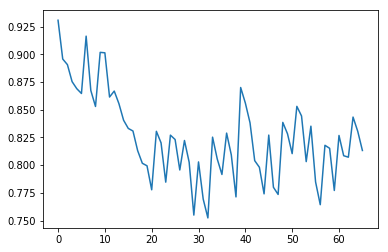

In [12]:
# In[78]:

# How about cropping out top 5% and bottom 25% part of the input?
# Also do something to take better nearby point
"""
Now dvlpments-
If multi-marked, try lower threshold, if still get multiple dark, move on, else choose the most dark one.
Make a questions class - It has options & their (4 by default) coordinates
pass array of questions to readResp: it just reads the coords and updates whether its marked or not.

TODO+ >> Maybe get a 'tone' of the image and decide the threshold(clipped) acc to it?

Sort Bad Verifies = Raebareli, Dhirangarh, Ambarnath, Korba

"""


#Expert :p
windowX,windowY = 0,0 
uniform_height = 1000 
uniform_width=1231

"""
TIPS FOR ADJUSTING THE THRESHOLD -
see the markedOMR
"""

template = cv2.imread('images/FinalCircle.png',cv2.IMREAD_GRAYSCALE) #,cv2.CV_8UC1/IMREAD_COLOR/UNCHANGED 
lontemplateinv = cv2.imread('images/lon-template-inv-resized.jpg',cv2.IMREAD_GRAYSCALE)
# lontemplateinv = imutils.rotate_bound(lontemplateinv,angle=180) 
# lontemplateinv = imutils.resize(lontemplateinv,height=int(lontemplateinv.shape[1]*0.75))
# cv2.imwrite('images/lontemplate-inv-resized.jpg',lontemplateinv)
once = 0
boxDimX,boxDimY=(17,17) # dims of the single square

allOMRs= glob.iglob(directory+'*/*/*/*'+ext)
# allOMRs = reversed(list(allOMRs))


timeNow=strftime("%I%p",localtime())

resultFile = 'results/Techno'+('KVJNV' if kv else '')+'Results2017-'+timeNow+'.csv'
if(not os.path.exists(resultFile)):
    with open(resultFile,'a') as f:
        results=[resultSheetCols]
        pd.DataFrame(results).to_csv(f,header=False,index=False) #no .T for single list
else:
    print('WARNING : Appending to Previous Result file!')
counter=1

"""TODO NOW
Done >Detected Images stored for each, also make an excel sheet connecting the filepath with roll
    >>markedOMRs - has ALL OMRS EXCEPT errorFiles(WITHOUT ENOUGH CIRCLE POINTS, debug OMRs)
    >>Should be corrected from Excel sheet.
yup >Manual Need ?
done >Proper Excel of ERRORS,VERIFY,WARNINGS,MULTIMARKED
done >Copy of those stored into verify folder
done >Set template of KV (its same,with change in Q5 only!), answer key & scheme of KV,
Rotate Feat.
KV Template RUN.

"""
#Make it live ?

# add rotate using templ2
# create err entries - fn,fp,batch 1000
p=int(time())
errorsArray=[sheetCols]
badRollsArray=[sheetCols]
verifyArray=[sheetCols]
multiMarkedArray=[sheetCols]

# start=35
with open(resultFile,'a') as f:
    # for i,filepath in enumerate(list(allOMRs)[start:start+5]):
    for i,filepath in enumerate(allOMRs):
        if(minWhiteTHR<mw):
            mw=minWhiteTHR
            print('white THR',mw)
        if(maxBlackTHR>mb):
            mb=maxBlackTHR
            print('black THR',mb)
        # num = str(i).zfill(4)
    #     filename=folder+prefix+num+ext
        finder = re.search(r'/.*/(.*)/(.*)/(.*)\.'+ext[1:],filepath,re.IGNORECASE)
        if(finder):
            squadlang = finder.group(1)
            squad,lang = squadlang[0],squadlang[1]
            squadlang = squadlang+'/'
            filename = finder.group(3)
            xeno = finder.group(2)
        else:
            filename = 'Nop'+str(i)
        sample3 = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE) 
        sample3 = imutils.resize(sample3,height=uniform_height) 
        sample3 = cv2.GaussianBlur(sample3,(3,3),0) 
        # show('sample3',sample3,1)
        # sample3 = imutils.rotate_bound(sample3,angle=90) 
        
        sample3crop,badscan = getROI(errorsArray,squadlang,filepath,filename+ext,filename,sample3,template,pause=0,
            lontemplinv= (lontemplateinv if autorotate else None),showimg=showimg,verbose=verbose, scaleRange=(0.70,1.05),thresholdCircle=thresholdCircle)
        #uniquify 
        newfilename = filename + '_' + xeno 
        # if(badwidth == 1):
        #     # Shifting the template! Resizing might work!!
        #     # Put detection images into the verify folder
        
        if(sample3crop is None):
            # Here badscan == -1 will come
            # print('Moving',sample3crop==None)
            err = move(results_2017error,filepath,errorpath+squadlang,newfilename+'.jpg')
            if(err):
                appendArr(err,errorsArray,ErrorFile)
            continue
        else:
            sample3crop = imutils.resize(sample3crop,height=uniform_height,width=uniform_width) 
        
        respArray=[]
        try: #TODO - resolve this try catch later 
            counter+=1
            OMRresponse,retimg,multimarked,multiroll = readResponse(squad,QTAGS[squad],VALUES[squad],pts[squad],(boxDimX,boxDimY),sample3crop,
                                              badscan=badscan,multimarkedTHR= thresholdRead-0.05 ,name =newfilename,save=(saveMarkedDir+squadlang if saveMarked else None),thresholdRead=thresholdRead,explain=explain,bord=-1)
            resp=processOMR(squad,OMRresponse) #convert to ABCD, getRoll,etc
            #Fill in the Blanks
            respArray.append(resp['roll']) #May append None
            for q in qNos['H']:#for align
                try:
                    respArray.append(resp['resp'][q])
                except:
                    respArray.append('')
            # err contains the rest = [results_2017batch,error,filename,filepath2]
            #This evaluates and Enters into Results sheet-
            score = evaluate(resp['resp'],Answers[squad+('K' if kv else '')],Sections[squad+('K' if kv else '')],explain=explain)

            if(multiroll or not (resp['roll'] is not None and len(resp['roll'])==11)):
                print('badRollNo, moving File: '+newfilename)
                err = move(badRollError,filepath,badRollspath+squadlang,newfilename+'.jpg')
                if(err):
                    appendArr(err+respArray,badRollsArray,badRollsFile)
            else:
                    
                if(badscan == 1):
                    # print('File Skipped from verify. Must be in Multimarked or Results')
                    err = move(verifyError,filepath,verifypath+squadlang,newfilename+'.jpg')
                    if(err):
                        appendArr(err+respArray,verifyArray,verifyFile)
                else:
                    if(multimarked == 0):
                        #TODO check that score stays the last column !
                        # err contains the rest = [results_2017batch,error,filename,filepath2]
                        results = [0,0,newfilename+'.jpg',filepath]+respArray+[score] #.append
                        filesNotMoved+=1;
                        pd.DataFrame(results).T.to_csv(f,header=False,index=False)
                        print((counter,newfilename+'.jpg',resp['roll'],','.join(respArray[1:]),'score : ',score))
                    else:

                        #multimarked file
                        print('multiMarked, moving File: '+newfilename)
                        err = move(multiMarkedError,filepath,multiMarkedpath+squadlang,newfilename+'.jpg')
                        if(err):
                            appendArr(err+respArray,multiMarkedArray,multiMarkedFile)
                

                

            if(showimg):
                show('processed'+newfilename+'.jpg',imutils.resize(retimg,height=700) ,1)#(0 if i<end else 1))
                
        except Exception as inst:
            print(counter,newfilename+'.jpg',"BAD ERROR : Moving file to errorFiles : ",inst)        
            err = move(results_2017error,filepath,errorpath+squadlang,'debug_'+newfilename+'.jpg')
            if(err):
                appendArr(err+respArray,errorsArray,ErrorFile)
        
        if(respArray==[]):
            respArray.append('') #Roll num
            for q in qNos[squad]:
                respArray.append('')

        if(errorsArray!=[] and len(errorsArray[-1])!=30 and len(errorsArray[-1])!=25):
            errorsArray[-1]=errorsArray[-1]+respArray

        if(verifyArray!=[] and len(verifyArray[-1])!=30 and len(verifyArray[-1])!=25):
            verifyArray[-1]=verifyArray[-1]+respArray

        if(badRollsArray!=[] and len(badRollsArray[-1])!=30 and len(badRollsArray[-1])!=25):
            badRollsArray[-1]=badRollsArray[-1]+respArray
        if(multiMarkedArray!=[] and len(multiMarkedArray[-1])!=30 and len(multiMarkedArray[-1])!=25):
            multiMarkedArray[-1]=multiMarkedArray[-1]+respArray


pd.DataFrame(errorsArray,columns=sheetCols).to_csv('feedsheets/errorSheet.csv',index=False,header=False)
pd.DataFrame(verifyArray,columns=sheetCols).to_csv('feedsheets/verifySheet.csv',index=False,header=False)
pd.DataFrame(badRollsArray,columns=sheetCols).to_csv('feedsheets/badRollSheet.csv',index=False,header=False)
pd.DataFrame(multiMarkedArray,columns=sheetCols).to_csv('feedsheets/multiMarkedSheet.csv',index=False,header=False)
# print(errorsArray,verifyArray,badRollsArray)


counterChecking=counter
takentimechecking=(int(time()-p)+1)
print('Finished Checking %d files in %d minute =>  %f sec/OMR:)' % (counterChecking,takentimechecking/60,float(takentimechecking)/float(counterChecking)))       
print('Final Read Thresholds : white %f black %f ' % (minWhiteTHR, maxBlackTHR))
print('Total files moved : %d ' % (filesMoved))
print('Total files not moved (shud match) : %d ' % (filesNotMoved))

# Use this data to train as +ve feedback
# print(thresholdCircles)
for x in [badThresholds,veryBadPoints,thresholdCircles]:
    if(x!=[]):
        x=pd.DataFrame(x)
        print( x.describe() )
        plt.plot(range(len(x)),x)
    else:
        print(x)
plt.show()